# LPDR 모델 튜닝 시나리오
데이터 드리프트 분석 기반 모델 재학습을 통한 추론성능 개선 파이프라인 구성<br>
<br>
* 기능 추가<br><br>
    * 복수 데이터셋에 대한 시각화 및 분석 기능<br>
    * 개별 데이터의 추가, 삭제 등 데이터 수정 기능<br>

## 데이터 수정 기능 테스트
기존 데이터셋에 새로운 데이터 추가<br>
데이터 분류 및 시각화 기능 제어

In [7]:
import fiftyone as fo
import fiftyone.brain as fob
import clip
import torch

import numpy as np

fo.list_datasets()

['kolp_dataset',
 'ls-annotation-example',
 'test_raw_imgs',
 'tunelpdr_cur',
 'tunelpdr_merged',
 'tunelpdr_ref']

In [8]:
fo.delete_dataset("tunelpdr_merged")
fo.delete_dataset("tunelpdr_ref")
fo.delete_dataset("tunelpdr_cur")

fo.list_datasets()

['kolp_dataset', 'ls-annotation-example', 'test_raw_imgs']

In [9]:
splits = ['train', 'val', 'test']
ref_dataset = fo.Dataset("tunelpdr_ref")
cur_dataset = fo.Dataset("tunelpdr_cur")

for split in splits:
    ref_dataset.add_dir(
        dataset_dir='../datasets/tunelpdr_ref',
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
    )
    cur_dataset.add_dir(
        dataset_dir='../datasets/tunelpdr_cur',
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
    )

 100% |███████████████| 2372/2372 [1.1s elapsed, 0s remaining, 2.2K samples/s]         
 100% |█████████████████| 284/284 [449.1ms elapsed, 0s remaining, 632.3 samples/s]     
 100% |███████████████████| 66/66 [41.5ms elapsed, 0s remaining, 1.6K samples/s]     
 100% |███████████████████| 40/40 [53.4ms elapsed, 0s remaining, 749.2 samples/s]    
 100% |███████████████████| 11/11 [9.1ms elapsed, 0s remaining, 1.2K samples/s]      
 100% |███████████████████| 19/19 [27.7ms elapsed, 0s remaining, 685.7 samples/s]    


In [10]:
from PIL import Image

# CLIP 모델 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 임베딩 생성 함수 : 이미지, 텍스트 구분
def get_embeddings(sample):

    if "image" in sample.tags:
        with torch.no_grad():
            inputs = preprocess(Image.open(sample.filepath)).unsqueeze(0).to(device)
            features = model.encode_image(inputs)

    # elif sample.tags[1] == "text":
    #     with torch.no_grad():
    #         inputs = clip.tokenize(sample.original_text, context_length=77, truncate=True).to(device)
    #         features = model.encode_text(inputs)

    return features.cpu().numpy().flatten()

In [11]:
tmp = []
test_sample = ref_dataset.first()
test_sample.tags.append("image")

test_embed = get_embeddings(test_sample)
tmp.append(test_embed)

tmp

[array([ 1.79878116e-01,  4.03871238e-01,  4.25222099e-01,  3.03541925e-02,
        -3.10817324e-02, -1.77015010e-02, -7.05806315e-02,  3.63875419e-01,
         1.32120892e-01, -1.83141872e-01,  2.72715569e-01,  7.70476013e-02,
         3.26890618e-01,  4.19722557e-01,  2.36908719e-01, -3.11335362e-02,
         4.65256795e-02,  3.43314469e-01, -2.21666649e-01, -2.38627940e-01,
        -2.70521134e-01,  2.00133592e-01, -1.22712106e-01, -1.72539100e-01,
        -3.63200724e-01,  5.27299106e-01,  2.49098957e-01, -8.77972692e-02,
        -1.95800707e-01,  7.03408644e-02, -6.15200818e-01, -4.54167128e-01,
        -1.84947178e-01,  7.68761188e-02,  1.45041391e-01,  3.92439812e-01,
         3.59354913e-01,  3.98844242e-01,  1.58378169e-01,  1.19709074e+00,
        -3.38561088e-02,  6.05815053e-01, -1.33198380e-01, -1.91920295e-01,
        -3.51850331e-01,  2.99904019e-01, -2.30872661e-01, -2.49551892e-01,
         2.80974746e-01,  2.05494642e-01, -7.16063380e-01, -4.67587709e-02,
         8.4

In [12]:
tmp2 = np.array(tmp)

tmp2.shape

(1, 512)

In [13]:
tmp3 = np.array(tmp2)

tmp3.shape

(1, 512)

In [14]:
embeddings = []

print("\nREF 임베딩 추출 시작\n")
cnt = 0
for sample in ref_dataset:
    sample.tags.append("image")
    sample.save()
    embedding = get_embeddings(sample)
    embeddings.append(embedding)
    cnt += 1
    if cnt % 100 == 0:
        print(f"{cnt}개 완료")

for sample, embedding in zip(ref_dataset, embeddings):
    sample['clip_embeddings'] = embedding.tolist()
    sample['source'] = 'ref'
    sample.save()


REF 임베딩 추출 시작

100개 완료
200개 완료
300개 완료
400개 완료
500개 완료
600개 완료
700개 완료
800개 완료
900개 완료
1000개 완료
1100개 완료
1200개 완료
1300개 완료
1400개 완료
1500개 완료
1600개 완료
1700개 완료
1800개 완료
1900개 완료
2000개 완료
2100개 완료
2200개 완료
2300개 완료
2400개 완료


In [15]:
print("\nCUR 임베딩 추출 시작\n")
cnt = 0
for sample in cur_dataset:
    sample.tags.append("image")
    sample.save()
    embedding = get_embeddings(sample)
    embeddings.append(embedding)
    cnt += 1
    if cnt % 100 == 0:
        print(f"{cnt}개 완료")

# 임베딩을 데이터셋에 추가
for sample, embedding in zip(cur_dataset, embeddings):
    sample['clip_embeddings'] = embedding.tolist()
    sample['source'] = 'cur'
    sample.save()


CUR 임베딩 추출 시작

100개 완료
200개 완료
300개 완료


In [16]:
print(len(ref_dataset))
print(len(cur_dataset))
print(len(ref_dataset) + len(cur_dataset))


2449
343
2792


In [17]:
ref_dataset.first()

<Sample: {
    'id': '674955f448e04fed5e020f2b',
    'media_type': 'image',
    'filepath': '/Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/datasets/tunelpdr_ref/train/images/-2-_jpg.rf.8f2d818f430bb290b487c996b15fb79d.jpg',
    'tags': ['train', 'image', 'image'],
    'metadata': None,
    'created_at': datetime.datetime(2024, 11, 29, 5, 49, 40, 638000),
    'last_modified_at': datetime.datetime(2024, 11, 29, 5, 51, 15, 991440),
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '674955f448e04fed5e020f28',
                'attributes': {},
                'tags': [],
                'label': 'License Plate',
                'bounding_box': [0.0, 0.5738281249999999, 0.0796875, 0.11171875],
                'mask': None,
                'confidence': None,
                'index': None,
            }>,
            <Detection: {
                'id': '674955f448e04fed5e020f29',
                'attributes': {},
                

In [18]:
cur_dataset.first()

<Sample: {
    'id': '674955f548e04fed5e022387',
    'media_type': 'image',
    'filepath': '/Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/datasets/tunelpdr_cur/train/images/video-12-1-_png.rf.67938ff02fb900eb928f1c52e4770608.jpg',
    'tags': ['train', 'image'],
    'metadata': None,
    'created_at': datetime.datetime(2024, 11, 29, 5, 49, 41, 740000),
    'last_modified_at': datetime.datetime(2024, 11, 29, 5, 51, 31, 677000),
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '674955f548e04fed5e022382',
                'attributes': {},
                'tags': [],
                'label': 'License Plate',
                'bounding_box': [0.13828125, 0.65625, 0.040625, 0.046875],
                'mask': None,
                'confidence': None,
                'index': None,
            }>,
            <Detection: {
                'id': '674955f548e04fed5e022383',
                'attributes': {},
                'tags': 

In [19]:
merged_dataset = fo.Dataset("tunelpdr_merged")
merged_dataset.merge_samples(ref_dataset)
merged_dataset.merge_samples(cur_dataset)

len(merged_dataset)

2792

In [20]:
embeddings = np.array(embeddings)

# 임베딩 시각화
results = fob.compute_visualization(
    merged_dataset,
    embeddings=embeddings,
    patches_field="clip_embeddings",
    brain_key="clip_embeddings",
    # num_dims=3,
    plot_points=True,
    verbose=True,
)

Generating visualization...


/Users/bhc/opt/anaconda3/envs/datadrift/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP( verbose=True)
Fri Nov 29 14:51:40 2024 Construct fuzzy simplicial set


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Fri Nov 29 14:51:43 2024 Finding Nearest Neighbors
Fri Nov 29 14:51:44 2024 Finished Nearest Neighbor Search
Fri Nov 29 14:51:45 2024 Construct embedding


Epochs completed:  13%| █▎         67/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  47%| ████▋      235/500 [00:01]

	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  82%| ████████▏  410/500 [00:01]

	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]


	completed  450  /  500 epochs
Fri Nov 29 14:51:47 2024 Finished embedding


In [21]:
session = fo.launch_app(merged_dataset)


## 데이터 임베딩 피쳐 비교

두 가지 방식으로 데이터셋을 비교, 분석
1. 임베딩 벡터의 산점도 그래프를 통해 시각적으로 얼마나 다른 형상, 위치를 보이는지 관측<br>
<br>
2. 다양한 지표를 활용해 데이터 임베딩의 분포 차이를 정량적으로 비교


### 1. 그래프 분석

각 데이터셋의 임베딩 벡터 인코드 및 시각화 관측

In [2]:
import fiftyone as fo
import fiftyone.brain as fob
import clip
import torch

import numpy as np
from PIL import Image
from tqdm import tqdm

# CLIP 모델 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## 필요한 기능 함수 정의
# 개별 데이터 태깅, 메타데이터 추가
def add_tags(dataset, source):
    
    for sample in dataset:
        sample.tags.append("image")
        sample['source'] = source
        sample.save()

# 임베딩 생성 함수 : 이미지, 텍스트 구분
def get_embeddings(sample):

    if "image" in sample.tags:
        with torch.no_grad():
            inputs = preprocess(Image.open(sample.filepath)).unsqueeze(0).to(device)
            features = model.encode_image(inputs)

    # elif sample.tags[1] == "text":
    #     with torch.no_grad():
    #         inputs = clip.tokenize(sample.original_text, context_length=77, truncate=True).to(device)
    #         features = model.encode_text(inputs)

    return features.cpu().numpy().flatten()

# 개별 데이터에 대한 임베딩 추출 및 임베딩 매핑 리스트 생성
def add_embeddings(dataset):

    print(f"{dataset}")
    for sample in tqdm(dataset, desc=f"{dataset.name} 임베딩 추출 중"):
        embedding = get_embeddings(sample)
        sample['clip_embeddings'] = embedding.tolist()
        sample.save()

def collect_image_embeddings_by_sample_id(dataset):

    image_embeddings = {}
    for sample in dataset:
        sample_id = sample.id
        if 'clip_embeddings' in sample:
            # 샘플 ID를 키로, 이미지 임베딩을 값으로 저장
            image_embeddings[sample_id] = np.array(sample['clip_embeddings'])

    return image_embeddings

In [4]:
fo.delete_dataset("tunelpdr_ref")
fo.delete_dataset("tunelpdr_cur")
fo.delete_dataset("tunelpdr_test")
fo.delete_dataset("tunelpdr_merged_embedtest")
fo.delete_dataset("tunelpdr_merged_embedtest2")
fo.delete_dataset("tunelpdr_merged")
fo.delete_dataset("tunelpdr_merged_v2")

In [5]:
fo.list_datasets()

['kolp_dataset', 'ls-annotation-example', 'test_raw_imgs']

In [6]:
splits = ['train', 'val', 'test']
ref_dataset = fo.Dataset("tunelpdr_ref")
cur_dataset = fo.Dataset("tunelpdr_cur")
test_dataset = fo.Dataset("tunelpdr_test")

for split in splits:
    ref_dataset.add_dir(
        dataset_dir='../datasets/tunelpdr_ref',
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
    )
    cur_dataset.add_dir(
        dataset_dir='../datasets/tunelpdr_cur',
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
    )
    test_dataset.add_dir(
        dataset_dir='../datasets/tunelpdr_test',
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
    )
add_tags(ref_dataset, "ref")
add_tags(cur_dataset, "cur")
add_tags(test_dataset, "test")

 100% |███████████████| 2372/2372 [966.9ms elapsed, 0s remaining, 2.5K samples/s]      
 100% |█████████████████| 284/284 [303.8ms elapsed, 0s remaining, 934.7 samples/s]    
 100% |███████████████| 7003/7003 [5.9s elapsed, 0s remaining, 1.3K samples/s]      
 100% |███████████████████| 66/66 [26.1ms elapsed, 0s remaining, 2.5K samples/s]      
 100% |███████████████████| 40/40 [48.1ms elapsed, 0s remaining, 832.0 samples/s]    
 100% |███████████████| 2001/2001 [1.7s elapsed, 0s remaining, 1.2K samples/s]         
 100% |███████████████████| 11/11 [6.7ms elapsed, 0s remaining, 1.6K samples/s]      
 100% |███████████████████| 19/19 [24.3ms elapsed, 0s remaining, 780.7 samples/s]    
 100% |█████████████████| 996/996 [814.9ms elapsed, 0s remaining, 1.2K samples/s]      


In [7]:
print(ref_dataset.first().tags)
print(ref_dataset.first()['source'])
print()

print(cur_dataset.first().tags)
print(cur_dataset.first()['source'])
print()

print(test_dataset.first().tags)
print(test_dataset.first()['source'])

['train', 'image']
ref

['train', 'image']
cur

['train', 'image']
test


In [8]:
merged_dataset = fo.Dataset("tunelpdr_merged")
merged_dataset.merge_samples(ref_dataset)
merged_dataset.merge_samples(cur_dataset)
merged_dataset.merge_samples(test_dataset)

print(len(merged_dataset))

12792


In [9]:
# 데이터셋에서 이미지 임베딩 수집
add_embeddings(merged_dataset)
image_embeddings_by_sample_id = collect_image_embeddings_by_sample_id(merged_dataset)

# 임베딩 시각화
results = fob.compute_visualization(
    merged_dataset,
    embeddings=image_embeddings_by_sample_id,
    brain_key="clip_embeddings",
    # num_dims=3,
    plot_points=True,
    verbose=True,
)

Name:        tunelpdr_merged
Media type:  image
Num samples: 12792
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    source:           fiftyone.core.fields.StringField


tunelpdr_merged 임베딩 추출 중: 100%|██████████| 12792/12792 [06:53<00:00, 30.91it/s]


Generating visualization...


/Users/bhc/opt/anaconda3/envs/datadrift/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP( verbose=True)
Tue Dec  3 15:04:05 2024 Construct fuzzy simplicial set
Tue Dec  3 15:04:05 2024 Finding Nearest Neighbors
Tue Dec  3 15:04:05 2024 Building RP forest with 11 trees


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Tue Dec  3 15:04:07 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Tue Dec  3 15:04:11 2024 Finished Nearest Neighbor Search
Tue Dec  3 15:04:12 2024 Construct embedding


Epochs completed:  10%| ▉          19/200 [00:01]

	completed  0  /  200 epochs
	completed  20  /  200 epochs


Epochs completed:  33%| ███▎       66/200 [00:01]

	completed  40  /  200 epochs
	completed  60  /  200 epochs


Epochs completed:  49%| ████▉      98/200 [00:01]

	completed  80  /  200 epochs
	completed  100  /  200 epochs


Epochs completed:  72%| ███████▎   145/200 [00:01]

	completed  120  /  200 epochs
	completed  140  /  200 epochs


Epochs completed:  88%| ████████▊  177/200 [00:02]

	completed  160  /  200 epochs
	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:02]


Tue Dec  3 15:04:15 2024 Finished embedding


In [10]:
session = fo.launch_app(merged_dataset)

### 2. 지표 분석
데이터셋의 임베딩에 따른 각종 분포 지표 비교

In [30]:
import numpy as np
from scipy.spatial.distance import cdist
from fiftyone import ViewField as F

# 소스별로 임베딩을 수집하는 함수
def collect_embeddings_by_source(dataset):
    embeddings_by_source = {'ref': [], 'cur': [], 'test': []}

    for source in embeddings_by_source.keys():
        view = dataset.match(F("source") == source)
        for sample in view:
            if 'clip_embeddings' in sample:
                embeddings_by_source[source].append(sample['clip_embeddings'])

    for source in embeddings_by_source:
        embeddings_by_source[source] = np.array(embeddings_by_source[source])

    return embeddings_by_source

def compute_mmd(X, Y, kernel='rbf', gamma=0.01):
    """두 데이터셋 X와 Y 간의 최대 평균 차이(MMD)를 계산합니다."""
    if kernel == 'rbf':
        # XX, YY, XY는 각각 X와 X, Y와 Y, X와 Y 간의 커널 매트릭스입니다.
        XX = np.exp(-gamma * cdist(X, X, 'sqeuclidean'))
        YY = np.exp(-gamma * cdist(Y, Y, 'sqeuclidean'))
        XY = np.exp(-gamma * cdist(X, Y, 'sqeuclidean'))
    else:
        raise ValueError("지원되지 않는 커널 타입입니다.")

    # MMD 계산
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
    return mmd

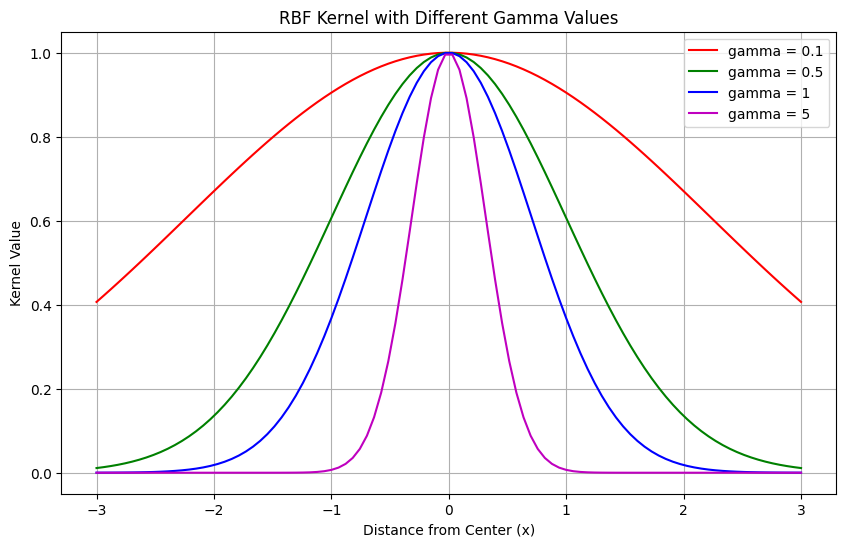

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# RBF 커널 함수
def rbf_kernel(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)

# 두 점 사이의 거리
x = np.linspace(-3, 3, 100)
y = np.zeros_like(x)

# 다양한 gamma 값에 대한 RBF 커널 값 계산
gamma_values = [0.1, 0.5, 1, 5]
colors = ['r', 'g', 'b', 'm']

plt.figure(figsize=(10, 6))
for gamma, color in zip(gamma_values, colors):
    kernel_values = [rbf_kernel(np.array([xi]), np.array([0]), gamma) for xi in x]
    plt.plot(x, kernel_values, label=f'gamma = {gamma}', color=color)

plt.title('RBF Kernel with Different Gamma Values')
plt.xlabel('Distance from Center (x)')
plt.ylabel('Kernel Value')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
fo.list_datasets()

['kolp_dataset',
 'ls-annotation-example',
 'test_raw_imgs',
 'tunelpdr_cur',
 'tunelpdr_merged',
 'tunelpdr_ref',
 'tunelpdr_test']

In [33]:
# 임베딩 수집
embeddings_by_source = collect_embeddings_by_source(merged_dataset)

# 각 소스의 임베딩 수 확인
for source, embeddings in embeddings_by_source.items():
    print(f"{source} 임베딩 수: {len(embeddings)}")

ref 임베딩 수: 2449
cur 임베딩 수: 343
test 임베딩 수: 10000


In [34]:
# MMD 계산
mmd_ref_cur = compute_mmd(embeddings_by_source['ref'], embeddings_by_source['cur'])
mmd_ref_test = compute_mmd(embeddings_by_source['ref'], embeddings_by_source['test'])
mmd_cur_test = compute_mmd(embeddings_by_source['cur'], embeddings_by_source['test'])

# 결과 출력
print(f"MMD(ref, cur): {mmd_ref_cur}")
print(f"MMD(ref, test): {mmd_ref_test}")
print(f"MMD(cur, test): {mmd_cur_test}")

MMD(ref, cur): 0.47949018300910673
MMD(ref, test): 0.4801281580392768
MMD(cur, test): 0.3586122889963441


In [ ]:
import evidently

from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import *
from evidently.metrics.data_drift.embedding_drift_methods import model, distance, ratio, mmd

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset
from evidently.tests import *

# mmd(maximum mean discrepancy) method report
report = Report(metrics = [
    EmbeddingsDriftMetric('full',
                            drift_method = mmd(
                                threshold = 0.015,
                                pca_components = None,
                                )
                         )
])

report.run(reference_data = embeddings_by_source['ref'], current_data = embeddings_by_source['cur'], 
           column_mapping = column_mapping)

report.show(mode='inline')

In [ ]:
from typing import Callable
from typing import Optional
from typing import Tuple

import numpy as np
import pandas as pd
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_kernels
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from evidently.calculations.stattests import get_stattest

DISTANCE_DICT = {
    "euclidean": euclidean,
    "cosine": cosine,
    "cityblock": cityblock,
    "chebyshev": chebyshev,
}
N_BOOTSTRAP = 100


def get_pca_df(
    reference_emb: pd.DataFrame, current_emb: pd.DataFrame, n_comp: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Takes two dataframes and reduces their dimensionality using the PCA method
    Args:
        reference_emb: reference embeddings data
        current_emb: current embeddings data
        n_comp: number of components to keep
    Returns:
        reference_emb_new: transformed reference_emb
        current_emb_new: transformed current_emb
    """
    pca = PCA(n_components=n_comp, random_state=0)
    return pd.DataFrame(pca.fit_transform(reference_emb)), pd.DataFrame(pca.transform(current_emb))


def distance(
    dist: str = "euclidean",
    threshold: float = 0.2,
    bootstrap: Optional[bool] = None,
    quantile_probability: float = 0.95,
    pca_components: Optional[int] = None,
) -> Callable:
    """Returns a function for calculating drift on embeddings using the average distance method with specified parameters
    Args:
        dist: "euclidean", "cosine", "cityblock" or "chebyshev"
        threshold: all values above this threshold means data drift. Applies when bootstrap != True
        bootstrap: boolean parameter to determine whether to apply statistical hypothesis testing
        quantile_probability: applies when bootstrap == True
        pca_components: number of components to keep
    Returns:
        func: a function for calculating drift, which takes in reference and current embeddings data
        and returns a tuple: drift score, whether there is drift, and the name of the drift calculation method.
    """

    def func(current_emb: pd.DataFrame, reference_emb: pd.DataFrame) -> Tuple[float, bool, str]:
        if pca_components:
            reference_emb, current_emb = get_pca_df(reference_emb, current_emb, pca_components)
        res = DISTANCE_DICT[dist](reference_emb.mean(axis=0), current_emb.mean(axis=0))
        if bootstrap:
            bstrp_res = []
            b_ref_size = int(reference_emb.shape[0] ** 2 / (reference_emb.shape[0] + current_emb.shape[0]))
            b_curr_size = int(
                current_emb.shape[0] * reference_emb.shape[0] / (reference_emb.shape[0] + current_emb.shape[0])
            )
            for i in range(N_BOOTSTRAP):
                np.random.seed(i)
                b_ref_idx = np.random.choice(reference_emb.shape[0], b_ref_size)
                b_curr_idx = np.random.choice(reference_emb.shape[0], b_curr_size)
                bstrp_res.append(
                    DISTANCE_DICT[dist](
                        reference_emb.iloc[b_ref_idx, :].mean(axis=0), reference_emb.iloc[b_curr_idx, :].mean(axis=0)
                    )
                )
            perc = np.percentile(bstrp_res, 100 * quantile_probability)
            return res, res > perc, "distance"
        return res, res > threshold, "distance"

    return func


def calc_roc_auc_random(y_test, i):
    np.random.seed(i)
    y_random_pred = np.random.rand(
        len(y_test),
    )
    roc_auc_random = roc_auc_score(y_test, y_random_pred)
    return roc_auc_random


def model(
    threshold: float = 0.55,
    bootstrap: Optional[bool] = None,
    quantile_probability: float = 0.95,
    pca_components: Optional[int] = None,
) -> Callable:
    """Returns a function for calculating drift on embeddings using the classifier method with specified parameters
    Args:
        threshold: all values above this threshold means data drift. Applies when bootstrap != True
        bootstrap: boolean parameter to determine whether to apply statistical hypothesis testing
        quantile_probability: applies when bootstrap == True
        pca_components: number of components to keep
    Returns:
        func: a function for calculating drift, which takes in reference and current embeddings data
        and returns a tuple: drift score, whether there is drift, and the name of the drift calculation method.
    """

    def func(current_emb: pd.DataFrame, reference_emb: pd.DataFrame) -> Tuple[float, bool, str]:
        if pca_components:
            reference_emb, current_emb = get_pca_df(reference_emb, current_emb, pca_components)
        reference_emb["target"] = [1] * reference_emb.shape[0]
        current_emb["target"] = [0] * current_emb.shape[0]
        data = pd.concat((reference_emb, current_emb))

        X_train, X_test, y_train, y_test = train_test_split(
            data.drop("target", axis=1), data["target"], test_size=0.5, random_state=42, shuffle=True
        )
        clf = SGDClassifier(loss="log", random_state=42)
        clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        if bootstrap:
            roc_auc_values = [calc_roc_auc_random(y_test, i) for i in range(100)]
            rand_roc_auc = np.percentile(roc_auc_values, 100 * quantile_probability)
            return roc_auc, roc_auc > rand_roc_auc, "model"
        return roc_auc, roc_auc > threshold, "model"

    return func


def ratio(
    component_stattest: str = "wasserstein",
    component_stattest_threshold: float = 0.1,
    threshold: float = 0.2,
    pca_components: Optional[int] = None,
) -> Callable:
    """Returns a function for calculating drift on embeddings using the ratio of drifted embeddings method
    with specified parameters
    Args:
        component_stattest: method for testing drift in a single embedding. Any drift detection method
        for a numerical feature implemented in evidently
        component_stattest_threshold: threshold for testing drift in a single embedding
        threshold: all values above this threshold means data drift
        pca_components: number of components to keep
    Returns:
        func: a function for calculating drift, which takes in reference and current embeddings data
        and returns a tuple: drift score, whether there is drift, and the name of the drift calculation method.
    """

    def func(current_emb: pd.DataFrame, reference_emb: pd.DataFrame) -> Tuple[float, bool, str]:
        if pca_components:
            reference_emb, current_emb = get_pca_df(reference_emb, current_emb, pca_components)
        stattest_func = get_stattest(reference_emb.iloc[:, 0], current_emb.iloc[:, 0], "num", component_stattest)
        n_drifted = 0
        for i in range(reference_emb.shape[1]):
            drift_result = stattest_func(
                reference_emb.iloc[:, i],
                current_emb.iloc[:, i],
                feature_type="num",
                threshold=component_stattest_threshold,
            )
            if drift_result.drifted:
                n_drifted += 1
        return n_drifted / reference_emb.shape[1], n_drifted / reference_emb.shape[1] > threshold, "ratio"

    return func


def MMD2u(K, m, n):
    """The MMD^2_u unbiased statistic."""
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    return (
        1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum())
        + 1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum())
        - 2.0 / (m * n) * Kxy.sum()
    )


def MMD2u_bstrp(K, m, n, x_idx, y_idx):
    """The MMD^2_u unbiased statistic for bootstrap subsample."""
    Kx = K[[[idx] for idx in x_idx], x_idx]
    Ky = K[[[idx] for idx in y_idx], y_idx]
    Kxy = K[[[idx] for idx in x_idx], y_idx]
    return (
        1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum())
        + 1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum())
        - 2.0 / (m * n) * Kxy.sum()
    )


def mmd(
    threshold: float = 0.015,
    bootstrap: Optional[bool] = None,
    quantile_probability: float = 0.05,
    pca_components: Optional[int] = None,
) -> Callable:
    """Returns a function for calculating drift on embeddings using the mmd method with specified parameters
    Args:
        threshold: all values above this threshold means data drift. Applies when bootstrap != True
        bootstrap: boolean parameter to determine whether to apply statistical hypothesis testing
        quantile_probability: applies when bootstrap == True
        pca_components: number of components to keep
    Returns:
        func: a function for calculating drift, which takes in reference and current embeddings data
        and returns a tuple: drift score, whether there is drift, and the name of the drift calculation method.
    """

    def func(current_emb: pd.DataFrame, reference_emb: pd.DataFrame) -> Tuple[float, bool, str]:
        if pca_components:
            reference_emb, current_emb = get_pca_df(reference_emb, current_emb, pca_components)
        x = reference_emb
        y = current_emb
        m = len(x)
        n = len(y)
        pair_dists = pairwise_distances(
            x.sample(min(m, int(1000 * n / m)), random_state=0),
            y.sample(min(n, 1000), random_state=0),
            metric="euclidean",
            n_jobs=-1,
        )
        sigma2 = np.median(pair_dists) ** 2
        xy = np.vstack([x, y])
        K = pairwise_kernels(xy, metric="rbf", gamma=1.0 / sigma2)
        mmd2u = MMD2u(K, m, n)
        if bootstrap:
            pair_dists_bstrp = pairwise_distances(x.sample(min(m, 1000), random_state=0), metric="euclidean", n_jobs=-1)
            sigma2_x = np.median(pair_dists_bstrp) ** 2
            gamma_x = 1.0 / sigma2_x
            K = pairwise_kernels(x, metric="rbf", gamma=gamma_x)
            x_size = int(m * m / (m + n))
            y_size = int(m * n / (m + n))
            bstrp_res = []
            for i in range(N_BOOTSTRAP):
                np.random.seed(i)
                x_idxs = np.random.choice(m, x_size)
                y_idxs = np.random.choice(m, y_size)
                bstrp_res.append(MMD2u_bstrp(K, x_size, y_size, x_idxs, y_idxs))
                perc = np.percentile(bstrp_res, 100 * quantile_probability)
            return max(mmd2u, 0), mmd2u > perc, "mmd"
        else:
            return max(mmd2u, 0), mmd2u > threshold, "mmd"

    return func

## 모델 테스트 #1
다른 임베딩 피쳐를 가지는 데이터셋에 대한 추론성능 비교<br>
<br>
* 학습 모델 1 : "tunelpdr_ref" 데이터셋을 학습한 모델 (Reference Dataset : 학습을 위한 실험실용 훈련 데이터셋을 가정)<br>

In [24]:
import os

os.getcwd()

'/Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/notebooks'

In [22]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

ref_dataset_path = "../datasets/tunelpdr_ref/"
cur_dataset_path = "../datasets/tunelpdr_cur/"
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:01<00:00, 4.88MB/s]


In [25]:
from pathlib import Path

# Define the absolute path for 'data.yaml'
data_path = str(Path(ref_dataset_path + 'dataset.yaml').resolve())

# Train the model
model.train(
    data=data_path,  # Path to the data configuration file
    epochs=10,                        # Number of training epochs
    imgsz=640,                        # Image size
    batch=4,                         # Batch size
    device="mps"                          # GPU device index (use 'cpu' for CPU training)
)

New https://pypi.org/project/ultralytics/8.3.39 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.25 🚀 Python-3.12.5 torch-2.4.1 MPS (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/datasets/tunelpdr_ref/dataset.yaml, epochs=10, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks

train: Scanning /Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/datasets/tunelpdr_ref/train/labels... 2372 images, 7 backgrounds, 0 corrupt: 100%|██████████| 2372/2372 [00:00<00:00, 2818.31it/s]

train: New cache created: /Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/datasets/tunelpdr_ref/train/labels.cache



INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/datasets/tunelpdr_ref/valid/labels... 66 images, 1 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 2805.78it/s]

val: New cache created: /Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/datasets/tunelpdr_ref/valid/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.37G      1.061      1.872      1.418          4        640: 100%|██████████| 593/593 [04:35<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:09<01:14,  9.26s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:13<00:42,  6.02s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:19<00:36,  6.08s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:23<00:26,  5.27s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:28<00:20,  5.24s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:32<00:14,  4.74s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:35<00:08,  4.32s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:45<00:00,  5.00s/it]


                   all         66         73       0.89      0.507      0.526      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.33G      1.007     0.9737      1.344          4        640: 100%|██████████| 593/593 [07:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:03<00:30,  3.75s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:09<00:33,  4.82s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:14<00:30,  5.13s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:19<00:25,  5.10s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:25<00:21,  5.33s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:31<00:16,  5.61s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:36<00:10,  5.45s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:44<00:00,  4.89s/it]

                   all         66         73      0.925      0.339      0.347      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.45G     0.9388     0.7298      1.266          4        640: 100%|██████████| 593/593 [08:27<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:03<00:29,  3.75s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:10<00:38,  5.46s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:16<00:33,  5.55s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:20<00:24,  4.92s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:27<00:23,  5.94s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:36<00:20,  6.93s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:42<00:13,  6.71s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:51<00:00,  5.72s/it]

                   all         66         73       0.87      0.367      0.363      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      5.74G     0.9093     0.6508      1.255          4        640: 100%|██████████| 593/593 [15:14<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:05<00:46,  5.81s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:11<00:39,  5.67s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:16<00:31,  5.33s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:20<00:24,  4.93s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:27<00:23,  5.79s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:34<00:18,  6.12s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:41<00:12,  6.39s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:50<00:00,  5.56s/it]


                   all         66         73      0.995      0.205      0.221      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      7.01G     0.8491     0.5623      1.202          6        640: 100%|██████████| 593/593 [22:12<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:05<00:45,  5.69s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:13<00:47,  6.72s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:18<00:35,  5.91s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:25<00:33,  6.69s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:31<00:24,  6.16s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:38<00:19,  6.42s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:47<00:14,  7.24s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:54<00:07,  7.25s/it]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:59<00:00,  6.57s/it]


                   all         66         73      0.977      0.192      0.203      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      8.26G     0.8109     0.5156      1.173          4        640: 100%|██████████| 593/593 [25:34<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:10<01:22, 10.34s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:16<00:56,  8.06s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:22<00:43,  7.20s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:30<00:37,  7.44s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:44<00:20,  6.89s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:47<00:11,  5.69s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:52<00:05,  5.54s/it]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:55<00:00,  6.21s/it]


                   all         66         73      0.943       0.26      0.309      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      9.54G     0.7705     0.4725      1.135          4        640: 100%|██████████| 593/593 [3:04:10<00:00, 18.64s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:05<00:47,  5.96s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:09<00:32,  4.60s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:15<00:31,  5.25s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:21<00:27,  5.50s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:26<00:21,  5.35s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [05:53<05:44, 114.70s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [06:03<00:00, 40.40s/it] 


                   all         66         73      0.962       0.37      0.492      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      10.8G     0.7238     0.4358      1.099          4        640: 100%|██████████| 593/593 [28:31:21<00:00, 173.16s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [32:37<4:20:56, 1957.07s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [39:06<2:00:46, 1035.18s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [39:15<56:37, 566.20s/it]   

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [39:26<28:56, 347.25s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [39:31<14:54, 223.64s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [39:42<07:34, 151.37s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [1:27:23<34:34, 1037.45s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [2:17:20<00:00, 915.57s/it] 


                   all         66         73      0.969      0.429      0.451      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      12.1G     0.6772        0.4      1.073          4        640: 100%|██████████| 593/593 [30:38:37<00:00, 186.03s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:12<01:36, 12.09s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:51<01:43, 17.30s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [01:04<01:17, 15.59s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [01:34<01:22, 20.52s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [02:31<01:38, 32.91s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [03:41<01:30, 45.21s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [04:23<00:00, 29.26s/it]


                   all         66         73      0.884      0.418       0.47      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      12.1G      0.622     0.3895     0.9318          4        640:   2%|▏         | 9/593 [04:31<1:48:46, 11.18s/it] 

In [1]:
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/last.pt")
model.train(
    resume=True,
)

New https://pypi.org/project/ultralytics/8.3.39 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.25 🚀 Python-3.12.5 torch-2.4.1 MPS (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=runs/detect/train2/weights/last.pt, data=/Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/datasets/tunelpdr_ref/dataset.yaml, epochs=10, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=0, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=runs/detect/train2/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=

train: Scanning /Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/datasets/tunelpdr_ref/train/labels.cache... 2372 images, 7 backgrounds, 0 corrupt: 100%|██████████| 2372/2372 [00:00<?, ?it/s]
/Users/bhc/opt/anaconda3/envs/datadrift/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /Users/bhc/Desktop/dev/drift_v1/datadrift_app_engine/datasets/tunelpdr_ref/valid/labels.cache... 66 images, 1 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training runs/detect/train2/weights/last.pt from epoch 10 to 10 total epochs
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.26G     0.6545     0.3819      1.055          4        640: 100%|██████████| 593/593 [03:42<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:46<00:00,  5.13s/it]


                   all         66         73      0.852      0.869      0.896      0.658

1 epochs completed in 0.076 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.25 🚀 Python-3.12.5 torch-2.4.1 MPS (Apple M2 Pro)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


                   all         66         73      0.852      0.871      0.896      0.658
Speed: 2.0ms preprocess, 30.9ms inference, 0.0ms loss, 46.5ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x5a0e24bf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    